## Import

In [9]:
import random
import pandas as pd
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet18
from torchvision import transforms

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

In [10]:
import pandas as pd
import os
from datasets import Dataset, Image
import random
from straug.geometry import Rotate

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [12]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS':15,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':256,
    'NUM_WORKERS':4, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

## Fixed RandomSeed

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [14]:
default_path = "C:/Users/Jo/PYDATAexam/train/" 
df = pd.read_csv('C:/Users/Jo/PYDATAexam/train.csv')

df['img_path'] = df['img_path'].apply(lambda x: default_path + x.split('/')[2])

In [15]:
default_path = "C:/Users/Jo/PYDATAexam/test/"
test = pd.read_csv("../test.csv")

test['img_path'] = test['img_path'].apply(lambda x: default_path + x.split('/')[2])

In [16]:
# 제공된 학습데이터 중 1글자 샘플들의 단어사전이 학습/테스트 데이터의 모든 글자를 담고 있으므로 학습 데이터로 우선 배치
df['len'] = df['label'].str.len()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76888 entries, 0 to 76887
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        76888 non-null  object
 1   img_path  76888 non-null  object
 2   label     76888 non-null  object
 3   len       76888 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


## CustomDataset

In [18]:
import PIL.Image

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.train_mode = train_mode
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, index):
        image = PIL.Image.open(self.img_path_list[index]).convert('RGB')
        
        if self.train_mode:
            image = self.train_transform(image)
        else:
            image = self.test_transform(image)
            
        if self.label_list is not None:
            text = self.label_list[index]
            return image, text
        else:
            return image
    
    # Image Augmentation
    def train_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)
    
    def test_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

# Image Augmentation Test

In [19]:
import cv2
import matplotlib.pyplot as plt

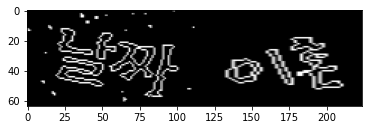

In [13]:
select1, select2 = random.randint(0, 76888), random.randint(0, 76888)
imgFile1 = f'../train/TRAIN_{select1:05d}.png'
imgFile2 = f'../train/TRAIN_{select2:05d}.png'

# 이미지 읽기
img1 = cv2.imread(imgFile1, 1);
img2 = cv2.imread(imgFile2, 1);

# 사이즈 조절
img1 = cv2.resize(img1,(112,64))
img2 = cv2.resize(img2,(112,64))

# 이미지 붙이기
addh = cv2.hconcat([img1, img2])

plt.imshow(addh)

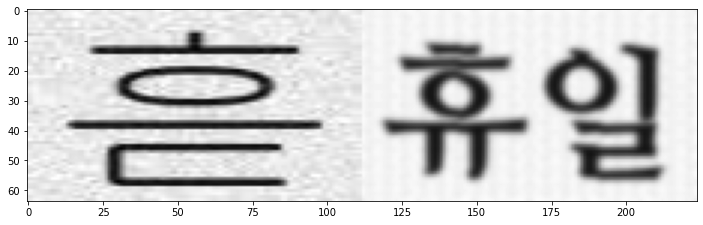

In [262]:
gray = cv2.cvtColor(addh, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

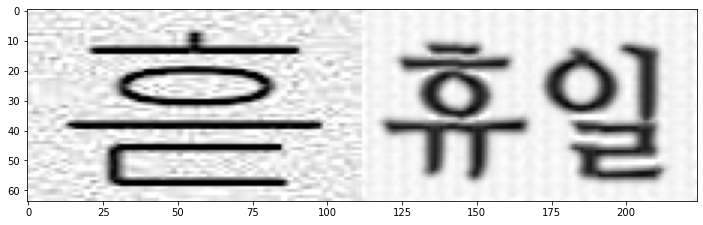

In [263]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

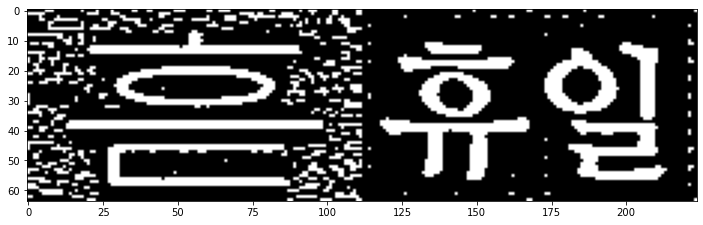

In [267]:
#img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    gray, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

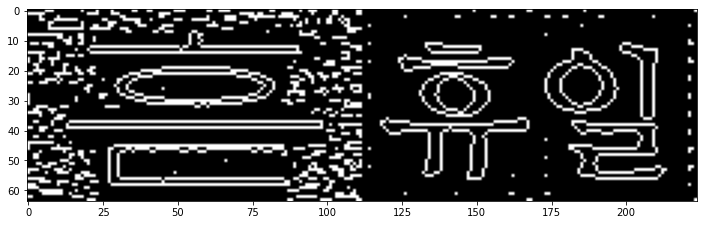

In [268]:
contours, _ = cv2.findContours(
                            img_thresh, 
                            mode=cv2.RETR_LIST, 
                            method=cv2.CHAIN_APPROX_SIMPLE
                              )

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

In [22]:
df_len_count = pd.DataFrame(df['len'].value_counts())
df_len_count.reset_index(inplace=True)
df_len_count.columns = ['len', 'len_count']

display(df_len_count)

,len,len_count
0,2,28631
1,1,23703
2,3,13514
3,4,9988
4,5,1026
5,6,26


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76888 entries, 0 to 76887
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        76888 non-null  object
 1   img_path  76888 non-null  object
 2   label     76888 non-null  object
 3   len       76888 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [24]:
len2count = {k:v for k,v in zip(df_len_count['len'], df_len_count['len_count'])}

In [25]:
len2count

{2: 28631, 1: 23703, 3: 13514, 4: 9988, 5: 1026, 6: 26}

# New image data Augmentation

In [26]:
import os
os.makedirs("../cut_mix", exist_ok=True)

In [27]:
idx = 76889 
for i in tqdm(range(5000)):
    # image select
    select1, select2 = random.randint(0, 76889), random.randint(0, 76889)
    imgFile1 = f'../train/TRAIN_{select1:05d}.png'
    imgFile2 = f'../train/TRAIN_{select2:05d}.png'
    
    if df['len'][select1] + df['len'][select2] > 6:
        continue   
    if len2count[df['len'][select1] + df['len'][select2]] > 30000:
        continue
    
    # image read
    img1 = cv2.imread(imgFile1, 1);
    img2 = cv2.imread(imgFile2, 1);
    
    addh = cv2.hconcat([img1, img2])
    
    # augmentation
    height, width, channel = addh.shape
    gray = cv2.cvtColor(addh, cv2.COLOR_BGR2GRAY)
    
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # 회색 변환(channel 수 감소)
    img_gray = cv2.cvtColor(addh, cv2.COLOR_BGR2GRAY)

    # 이진수 변환(흑 / 백)
    img_binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    img = cv2.morphologyEx(img_binary, cv2.MORPH_OPEN, structuringElement)
    
    # dataframe data add
    new_data = {
        'id' : f"TRAIN_{idx:05d}",
        'img_path' : f"../cut_mix/TRAIN_{idx:05d}.png",
        'label' : df['label'][select1] + df['label'][select2],
        'len' : df['len'][select1] + df['len'][select2]
    }
    
    df = df.append(new_data, ignore_index=True)
    
    cv2.imwrite(f"../cut_mix/TRAIN_{idx:05d}.png", img)
    idx += 1
    len2count[df['len'][select1] + df['len'][select2]] += 1

  0%|          | 0/5000 [00:00<?, ?it/s]

In [28]:
df_len_count = pd.DataFrame(df['len'].value_counts())
df_len_count.reset_index(inplace=True)
df_len_count.columns = ['len', 'len_count']

display(df_len_count)

,len,len_count
0,2,29117
1,1,23703
2,3,14597
3,4,11228
4,5,2093
5,6,734


In [29]:
df.head()

,id,img_path,label,len
0,TRAIN_00000,C:/Users/Jo/PYDATAexam/train/TRAIN_00000.png,빨간색,3
1,TRAIN_00001,C:/Users/Jo/PYDATAexam/train/TRAIN_00001.png,머,1
2,TRAIN_00002,C:/Users/Jo/PYDATAexam/train/TRAIN_00002.png,차차,2
3,TRAIN_00003,C:/Users/Jo/PYDATAexam/train/TRAIN_00003.png,써,1
4,TRAIN_00004,C:/Users/Jo/PYDATAexam/train/TRAIN_00004.png,놓치다,3


In [30]:
train_v1 = df[df['len']==1]
## 제공된 학습데이터 중 2글자 이상의 샘플들에 대해서 단어길이를 고려하여 Train (80%) / Validation (20%) 분할
df2 = df[df['len']>1]
train_v2, val, _, _ = train_test_split(df2, df2['len'], test_size=0.2, random_state=CFG['SEED'])
## 학습 데이터로 우선 배치한 1글자 샘플들과 분할된 2글자 이상의 학습 샘플을 concat하여 최종 학습 데이터로 사용
train = pd.concat([train_v1, train_v2])
print(len(train), len(val))

# 학습 데이터로부터 단어 사전(Vocabulary) 구축
train_gt = [gt for gt in train['label']]
print(len(train_gt))
dt=pd.DataFrame(train_gt)
dt.tail()
train_gt = "".join(train_gt)
letters = sorted(list(set(list(train_gt))))
print(len(letters))
vocabulary = ["-"] + letters
print(len(vocabulary))
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
char2idx = {v:k for k,v in idx2char.items()}

69918 11554
69918
2349
2350


In [31]:
train.tail()

,id,img_path,label,len
59671,TRAIN_59671,C:/Users/Jo/PYDATAexam/train/TRAIN_59671.png,혼잣말,3
78055,TRAIN_78056,../cut_mix/TRAIN_78056.png,장차겨자,4
29612,TRAIN_29612,C:/Users/Jo/PYDATAexam/train/TRAIN_29612.png,계속,2
1286,TRAIN_01286,C:/Users/Jo/PYDATAexam/train/TRAIN_01286.png,단계,2
50289,TRAIN_50289,C:/Users/Jo/PYDATAexam/train/TRAIN_50289.png,손수,2


In [32]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

## Model Define

In [33]:
class RecognitionModel(nn.Module):
    def __init__(self, num_chars=len(char2idx), rnn_hidden_size=256):
        super(RecognitionModel, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        
        # CNN Backbone = 사전학습된 resnet18 활용
        # https://arxiv.org/abs/1512.03385
        resnet = resnet18(pretrained=True)
        # CNN Feature Extract
        resnet_modules = list(resnet.children())[:-3]
        self.feature_extract = nn.Sequential(
            *resnet_modules,
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.linear1 = nn.Linear(1024, rnn_hidden_size)
        
        # RNN
        self.rnn = nn.RNN(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, x):
        # CNN
        x = self.feature_extract(x) # [batch_size, channels, height, width]
        x = x.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
         
        batch_size = x.size(0)
        T = x.size(1)
        x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        x = self.linear1(x)
        
        # RNN
        x, hidden = self.rnn(x)
        
        output = self.linear2(x)
        output = output.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        
        return output

## Define CTC Loss

In [34]:
criterion = nn.CTCLoss(blank=0) # idx 0 : '-'

In [35]:
def encode_text_batch(text_batch):
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [36]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 

    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

## Train

In [37]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    
    best_loss = 999999
    best_model = None
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for image_batch, text_batch in tqdm(iter(train_loader)):
            image_batch = image_batch.to(device)
            
            optimizer.zero_grad()
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        _val_loss = validation(model, val_loader, device)
        print(f'Epoch : [{epoch}] Train CTC Loss : [{_train_loss:.5f}] Val CTC Loss : [{_val_loss:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_loss)
        
        if best_loss > _val_loss:
            best_loss = _val_loss
            best_model = model
    
    return best_model

## Validation

In [38]:
def validation(model, val_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for image_batch, text_batch in tqdm(iter(val_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss

In [39]:
train_loader

## Run!!

In [40]:
model = RecognitionModel()
#model = torch.load("./resnet18.pt")
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [1] Train CTC Loss : [6.82761] Val CTC Loss : [5.33425]


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [2] Train CTC Loss : [5.08610] Val CTC Loss : [3.70583]


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [3] Train CTC Loss : [3.15902] Val CTC Loss : [2.06384]


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [4] Train CTC Loss : [2.01368] Val CTC Loss : [1.46639]


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [5] Train CTC Loss : [1.39037] Val CTC Loss : [1.10050]


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [6] Train CTC Loss : [0.99179] Val CTC Loss : [0.99906]


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [7] Train CTC Loss : [0.72620] Val CTC Loss : [0.91710]


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [8] Train CTC Loss : [0.52431] Val CTC Loss : [0.90057]


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [9] Train CTC Loss : [0.40228] Val CTC Loss : [0.81165]


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [10] Train CTC Loss : [0.29892] Val CTC Loss : [0.95040]


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [11] Train CTC Loss : [0.24336] Val CTC Loss : [0.84898]


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [12] Train CTC Loss : [0.15746] Val CTC Loss : [0.86998]
Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [13] Train CTC Loss : [0.06411] Val CTC Loss : [0.71649]


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [14] Train CTC Loss : [0.02593] Val CTC Loss : [0.72936]


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch : [15] Train CTC Loss : [0.01643] Val CTC Loss : [0.74163]


## Inference

In [41]:
test_dataset = CustomDataset(test['img_path'].values, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [42]:
def decode_predictions(text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for image_batch in tqdm(iter(test_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            
            preds.extend(text_batch_pred)
    return preds

In [43]:
predictions = inference(infer_model, test_loader, device)

  0%|          | 0/290 [00:00<?, ?it/s]

## Submission

In [44]:
# 샘플 별 추론결과를 독립적으로 후처리
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [45]:
submit = pd.read_csv('../sample_submission.csv')
submit['label'] = predictions
submit['label'] = submit['label'].apply(correct_prediction)

In [46]:
submit.to_csv('./submission.csv', index=False)